# **Chapter 2: Next-Generation Sequencing**
</br>

**Working with FASTQ**

Before we start coding, let's take a look at the FASTQ file, in which you will have many records, as shown in the following code:
</br>
`@SRR003258.1 30443AAXX:1:1:1053:1999 length=51`</br>
` ACCCCCCCCCACCCCCCCCCCCCCCCCCCCCCCCCCCACACACACCAACAC`</br>
 `+`</br>
` =IIIIIIIII5IIIIIII>IIII+GIIIIIIIIIIIIII(IIIII01&III` </b></br>



*   Line 1 starts with @, followed by a sequence identifier and a description string. The description string will vary from a sequencer or a database source, but will normally be amenable to automated parsing. 
*   The second line has the sequence DNA, which is just like a FASTA file. 


*   The third line is a +, sometimes followed by the description line on the first line.
*   The fourth line contains quality values for each base that's read on line two. Each letter encodes a Phred quality score (https://en.wikipedia.org/wiki/Phred_quality_score#:~:text=A%20Phred%20quality%20score%20is,in%20the%20Human%20Genome%20Project.), which assigns a probability of error to each read. This encoding can vary a bit among platforms. Be sure to check for this on your specific platform.







**Let's take a look at the following steps:**
</br>
You just need to download this ~28 MB file only once

In [1]:
# !rm -f SRR003265.filt.fastq.gz 2>/dev/null
!wget -nd ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/sequence_read/SRR003265.filt.fastq.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.


Let's open the file: 

In [ ]:
pip install biopython

In [5]:
import gzip
from Bio import SeqIO

We will open a GZIP file so that we can use the Python gzip module. We will
also specify the fastq format.</br>
 Note that some variations in this format will
impact the interpretation of the Phred quality scores. You may want to specify a
slightly different format. Refer to https://biopython.org/wiki/SeqIO for all
formats.

In [7]:
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
rec = next(recs)
print(rec.id, rec.description, rec.seq)
print(rec.letter_annotations)

SRR003265.31 SRR003265.31 3042NAAXX:3:1:1252:1819 length=51 GGGAAAAGAAAAACAAACAAACAAAAACAAAACACAGAAACAAAAAAACCA
{'phred_quality': [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 30, 23, 40, 32, 35, 29, 40, 16, 40, 40, 32, 35, 31, 40, 40, 39, 22, 40, 24, 20, 28, 31, 12, 31, 10, 22, 28, 13, 26, 20, 23, 23]}


Now, let's take a look at the distribution of nucleotide reads:

In [12]:
from collections import defaultdict
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')

cnt = defaultdict(int)

for rec in recs:
  for letter in rec.seq:
    cnt[letter] += 1

tot = sum(cnt.values())
for letter, cnt in cnt.items():
  print('%s: %.2f %d' % (letter, 100. * cnt / tot, cnt))

G: 20.68 5359334
A: 28.60 7411965
C: 21.00 5444053
T: 29.58 7666885
N: 0.14 37289


**Note that** there is a residual number for `N` calls. These are calls in which a sequencer reports an unknown base. </br>
In our FASTQ file example, we have
cheated a bit because we used a filtered file (the fraction of N calls will be
quite low). 
</br>Expect a much bigger number of N calls in a file that came out
of the sequencer unfiltered. 
</br>In fact, you can even expect something more
with regards to the spatial distribution of **N calls**.

Let's plot the distribution of Ns according to its read position:

In [16]:
#packages need for plotting
import seaborn as sns
import matplotlib.pyplot as plt

We open the file to parse again (remember that you do not use a list, but
iterate again). </br> We iterate through the file and get the position of any references to N. 
</br>Then, we plot the distribution of Ns as a function of the distance from the start of the sequence

(1.0, 51.0)

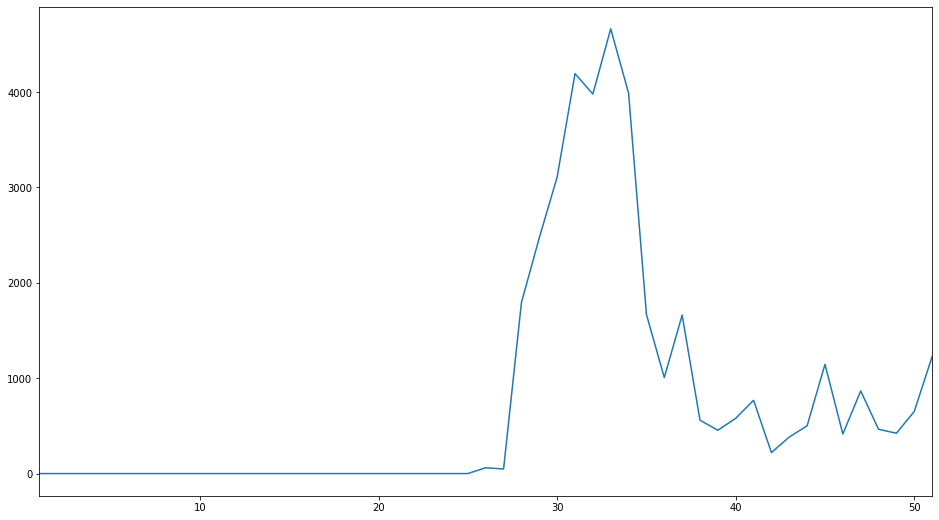

In [29]:
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='UTF-8'), 'fastq')
n_cnt = defaultdict(int)
for rec in recs:
    for i, letter in enumerate(rec.seq):
        pos = i + 1
        if letter == 'N':
          if pos in n_cnt.keys():
            n_cnt[pos] += 1
            
seq_len = max(n_cnt.keys())
positions = range(1, seq_len + 1)

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(positions, [n_cnt[x] for x in positions])
fig.suptitle('Number of N calls as a function of the distance from the start of the sequencer read')
ax.set_xlim(1, seq_len)
ax.set_xlabel('Read distance')
ax.set_ylabel('Number of N Calls')

You will see that until **position 25**, there are no errors. This is not what you will get from a typical sequencer output.</br> Our example file is already filtered, and the 1,000 genomes filtering rules enforce that no N calls can occur before position 25. </br>While we cannot study the behavior of Ns in this dataset before position 25, we can see that after position 25, the
distribution is far from uniform. There is an important lesson here, which is that the quantity of uncalled bases is position-dependent.</br> So, what about the quality of
reads?

**Let's study the distribution of Phred scores (that is, the quality of our reads:**

We will start by reopening the file (again) and initializing a default dictionary. </br> We then get the phred_quality letter annotation, but we ignore sequencing positions that are up to 24 base pairs from the start (because of the filtering of our FASTQ file, if you have an unfiltered file, you may want to drop this rule). </br> We
add the quality score to our default dictionary, and finally print it.

In [30]:
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
cnt_qual = defaultdict(int)

for rec in recs:
    for i, qual in enumerate(rec.letter_annotations['phred_quality']):
        if i < 25:
            continue
        if qual in cnt_qual.keys():   
          cnt_qual[qual] += 1

tot = sum(cnt_qual.values())

for qual, cnt in cnt_qual.items():
    print('%d: %.2f %d' % (qual, 100. * cnt / tot, cnt))

40: 22.76 3007221
16: 2.05 270431
32: 1.03 136763
35: 0.91 120704
31: 1.08 142464
39: 0.78 102568
22: 1.59 209905
24: 1.46 193259
20: 1.73 228923
28: 1.23 162226
12: 2.35 309918
10: 4.95 654154
13: 2.28 301033
26: 1.33 176263
23: 1.52 201164
37: 0.84 111179
34: 0.95 125624
21: 1.66 219602
30: 1.13 149449
33: 0.99 131291
25: 1.40 184846
17: 1.97 259779
38: 0.80 106290
4: 4.77 630923
36: 0.88 115701
18: 1.88 248982
11: 2.41 318303
19: 1.81 239621
5: 4.88 645266
9: 2.51 332259
3: 4.04 533458
27: 1.28 168902
8: 2.53 334410
29: 1.17 154892
15: 2.12 280719
7: 2.51 331743
2: 3.77 498679
14: 2.20 291341
6: 2.50 330834
1: 1.52 200558
0: 0.40 52229


More interestingly, we can plot the distribution of qualities according to their read position:

In this case, we will ignore both positions sequenced as 25 base pairs from the
start (again, remove this rule if you have unfiltered sequencer data) and the
maximum quality score for this file (40). </br> However, in your case, you can consider starting your plotting analysis with the maximum. You may want to check the maximum possible value for your sequencer hardware. Generally, as most calls can be performed with maximum quality, you may want to remove them if you are trying to understand where quality problems lie.

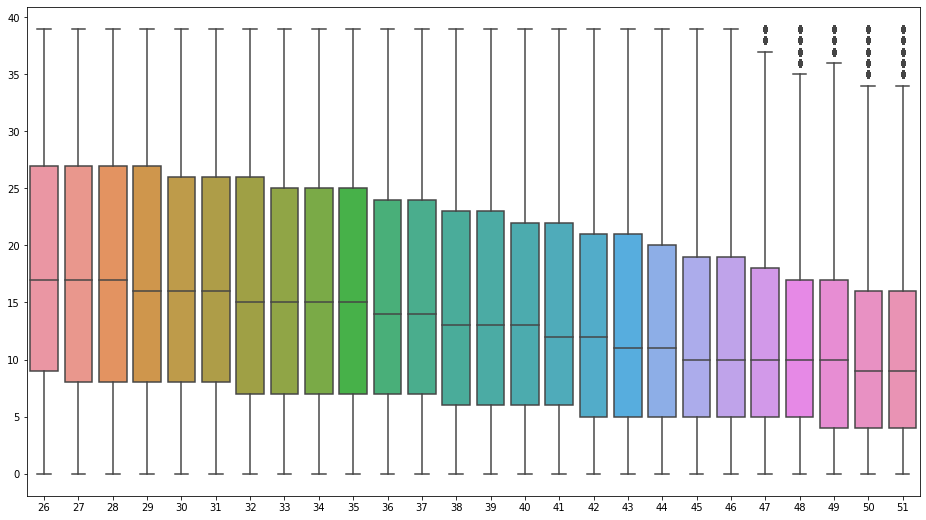

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz',
'rt', encoding='utf-8'), 'fastq')
n_cnt = defaultdict(int)
for rec in recs:
  for i, letter in enumerate(rec.seq):
    pos = i + 1
    if letter == 'N':
      n_cnt[pos] += 1

seq_len = max(n_cnt.keys())
positions = range(1, seq_len + 1)

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(positions, [n_cnt[x] for x in positions])
fig.suptitle('Number of N calls as a function of thedistance from the start of the sequencer read')
ax.set_xlim(1, seq_len)
ax.set_xlabel('Read distance')
ax.set_ylabel('Number of N Calls')


Although it's impossible to discuss all the variations of output coming from sequencer files, paired-end reads are worth mentioning because they are common and require a different processing approach. With paired-end sequencing, both ends of a DNA fragment are sequenced with a gap in the middle (called the insert). </br> In this case, two files will be produced: X_1.FASTQ and X_2.FASTQ. </br>Both files will have the same order and exact same
number of sequences. The first sequence will be in X_1 pairs with the first sequence of X_2, and so on. With regards to the programming technique, if you want to keep the pairing information, you might perform something like this:

Do this to download the paired end data. </br>
Be careful as this will be 1GB of data (and fully optional)

In [34]:
!rm -f SRR003265_1.filt.fastq.gz 2>/dev/null
!rm -f SRR003265_2.filt.fastq.gz 2>/dev/null
!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/sequence_read/SRR003265_1.filt.fastq.gz
!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/sequence_read/SRR003265_2.filt.fastq.gz

--2022-07-15 18:08:50--  ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/sequence_read/SRR003265_1.filt.fastq.gz
           => ‘SRR003265_1.filt.fastq.gz’
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.193.140
Connecting to ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.193.140|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/ftp/phase3/data/NA18489/sequence_read ... done.
==> SIZE SRR003265_1.filt.fastq.gz ... 502660639
==> PASV ... done.    ==> RETR SRR003265_1.filt.fastq.gz ... done.
Length: 502660639 (479M) (unauthoritative)

SRR003265_1.filt.fa 100%[===================>] 479.37M  4.32MB/s    in 88s     

2022-07-15 18:10:19 (5.46 MB/s) - ‘SRR003265_1.filt.fastq.gz’ saved [502660639]

--2022-07-15 18:10:19--  ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/sequence_read/SRR003265_2.filt.fastq.gz
           => ‘SRR003265_2.filt.fa

In [36]:
f1 = gzip.open('SRR003265_1.filt.fastq.gz', 'rt', encoding='utf8')
f2 = gzip.open('SRR003265_2.filt.fastq.gz', 'rt', encoding='utf8')
recs1 = SeqIO.parse(f1, 'fastq')
recs2 = SeqIO.parse(f2, 'fastq')
cnt = 0
for rec1, rec2 in zip(recs1, recs2):
    cnt +=1

print('Number of pairs: %d' % cnt)

Number of pairs: 9170808
